In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../../../model')
sys.path.append('../../../data')
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from load import get_data, get_patched_data, subsample
from utils import custom_cutout
from metrics import psnr, ssim
import losses

# Basic Setup 

In [2]:
gpu_id = 4
num_cores = 4
torch.cuda.set_device(gpu_id)

In [3]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'
model_pth = data_pth/f'EM/models/self_sv/inpainting'

## Resnet Feature loss

### Load critic model

In [4]:
bs = 8  # batch size
size = 256  # image size
random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                       min_length=15, max_length=25, use_on_y=False)
tfms = [[random_patch()], [random_patch()]]
data = get_patched_data(data_pth, hr_path, bs, tfms=tfms,
                        in_sz=size, out_sz=size)

In [5]:
critic_arch = models.resnet34
wd = 1e-3
superres_metrics = [F.mse_loss, psnr, ssim]
critic = unet_learner(data, critic_arch, wd=wd, 
                         loss_func=F.mse_loss,
                         metrics=superres_metrics,  
                         blur=True, 
                         norm_type=NormType.Weight, 
                         model_dir=model_pth)
gc.collect()

0

In [6]:
critic_name = '5.3_fastai_80epoch.pkl'
critic.model.load_state_dict(torch.load(model_pth/critic_name))

<All keys matched successfully>

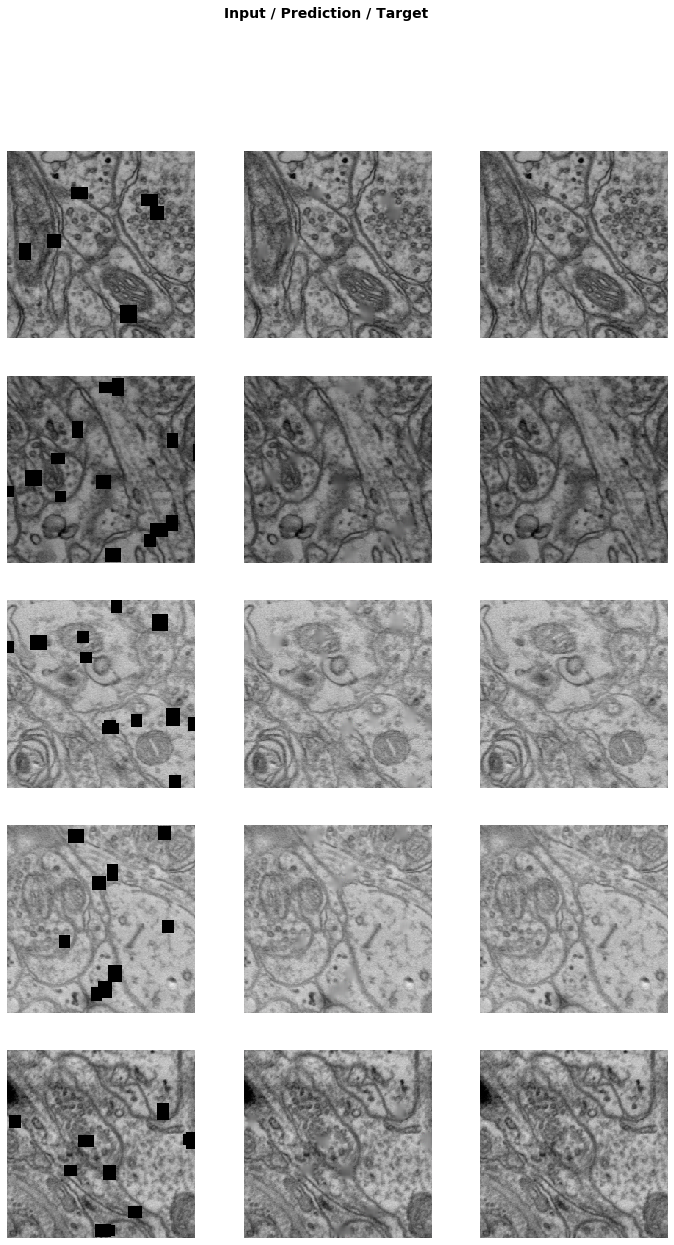

In [7]:
critic.show_results()

### Define the feature loss function

In [8]:
encoder = critic.model.eval()[0]
feature_maps = losses.find_layers(flatten_model(encoder))
num_layers = len(feature_maps)

In [9]:
feat_loss = losses.FeatureLoss(m_feat=encoder, layer_wgts=[1/num_layers for _ in range(num_layers)])

# Model

## Initialization

In [10]:
def data_func(bs, size, max_zoom):
    func = partial(get_data, data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path)
    data = func(bs=bs, in_sz=size, out_sz=size, max_zoom=max_zoom)
    if sample:
        return subsample(data)
    else:
        return data

In [11]:
sample = True
bs_3 = 8
size_3 = 512
db = data_func(bs=bs_3, size=size_3, max_zoom=2.)

In [12]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(db, arch, wd=wd, 
                         loss_func=feat_loss,
                         metrics=superres_metrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_pth)
gc.collect()

0

## Load Trained Model

### Full pretrained critic, sampled generator with transfer learning from critic

In [13]:
model_name = '5.20_inpaint_transfer_sampled_3.pkl'
learn.model.load_state_dict(torch.load(model_pth/model_name))

<All keys matched successfully>

In [14]:
learn.validate()

[0.4689583, tensor(0.0784), tensor(19.3528), tensor(0.2248)]

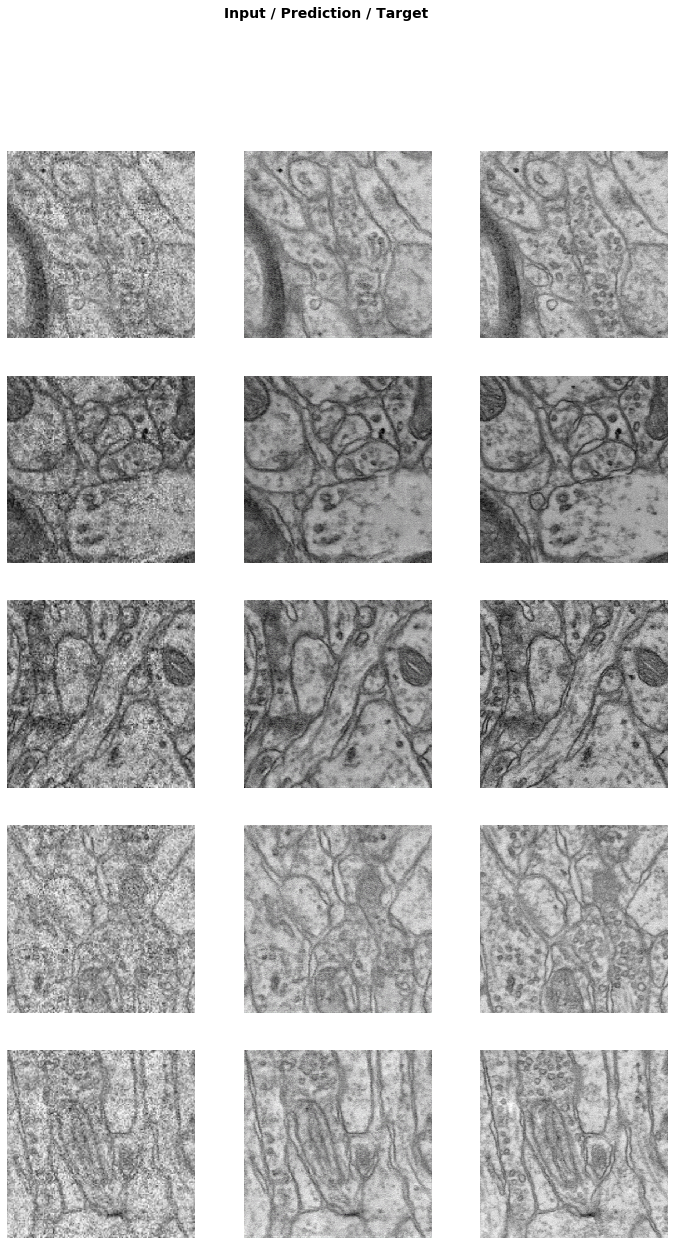

In [15]:
learn.show_results()

### Full pretrained critic, sampled generator with ImageNet pretraining

In [16]:
model_name = '5.20_inpaint_imagenet_sampled_3.pkl'
learn.model.load_state_dict(torch.load(model_pth/model_name))

<All keys matched successfully>

In [17]:
learn.validate()

[0.5340162, tensor(0.0828), tensor(19.1167), tensor(0.2171)]

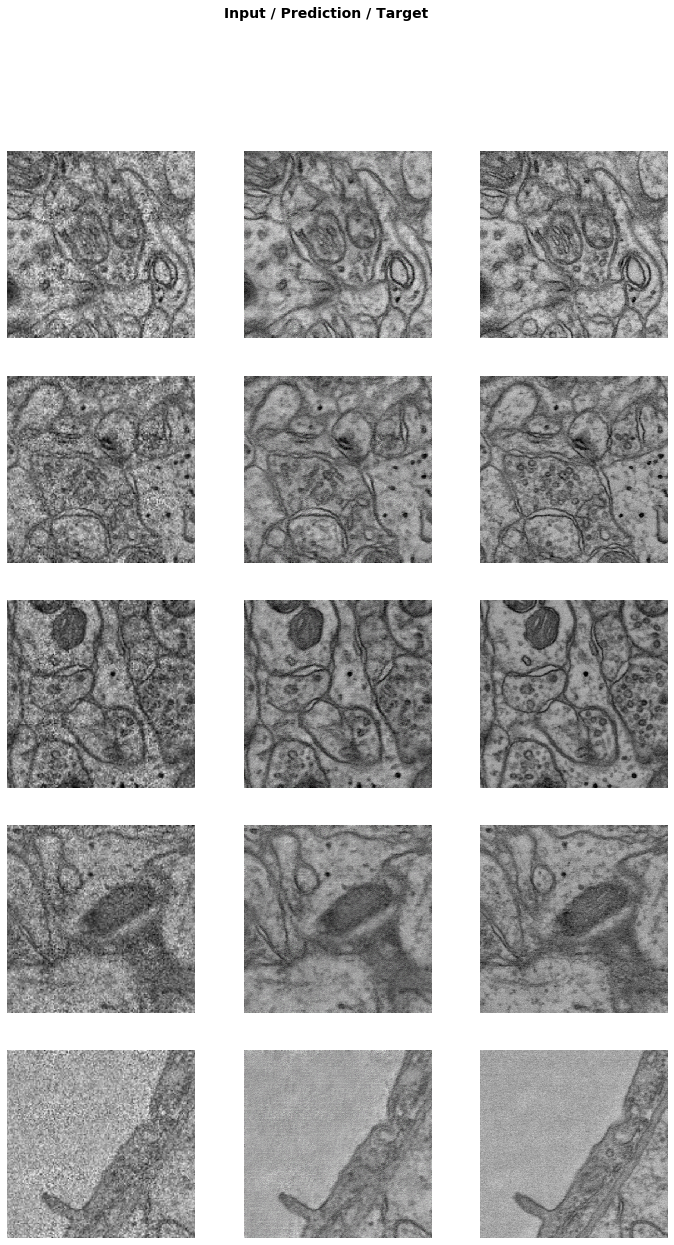

In [18]:
learn.show_results()

# Toddler expts

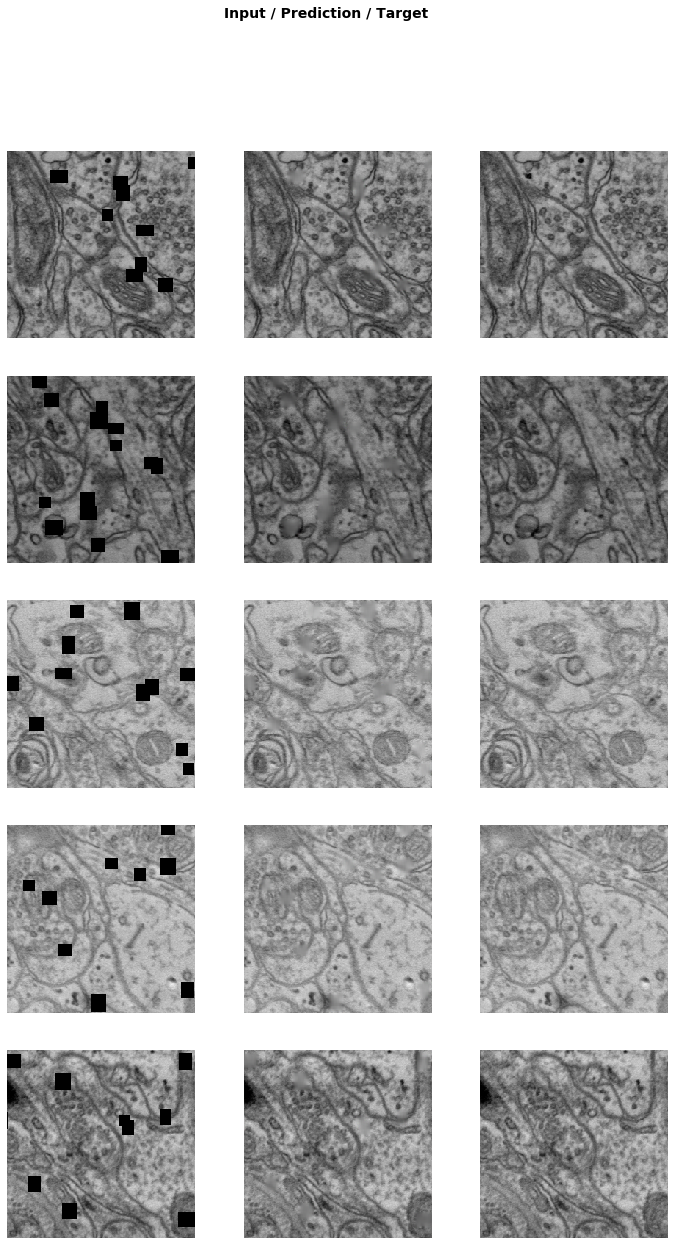

In [20]:
critic_name = '5.21_critic_toddler_best.pkl'
critic.model.load_state_dict(torch.load(model_pth/critic_name))
critic.show_results()

In [21]:
encoder = critic.model.eval()[0]
feature_maps = losses.find_layers(flatten_model(encoder))
num_layers = len(feature_maps)

feat_loss = losses.FeatureLoss(m_feat=encoder, layer_wgts=[1/num_layers for _ in range(num_layers)])

learn = unet_learner(db, arch, wd=wd, 
                         loss_func=feat_loss,
                         metrics=superres_metrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_pth)

### Toddler pretrained critic, sampled generator with ImageNet pretraining

In [22]:
model_name = '5.21_inpaint_imagenet_toddler_sampled_3.pkl'
learn.model.load_state_dict(torch.load(model_pth/model_name))

<All keys matched successfully>

In [23]:
learn.validate()

[0.49914405, tensor(0.0796), tensor(19.2691), tensor(0.2177)]

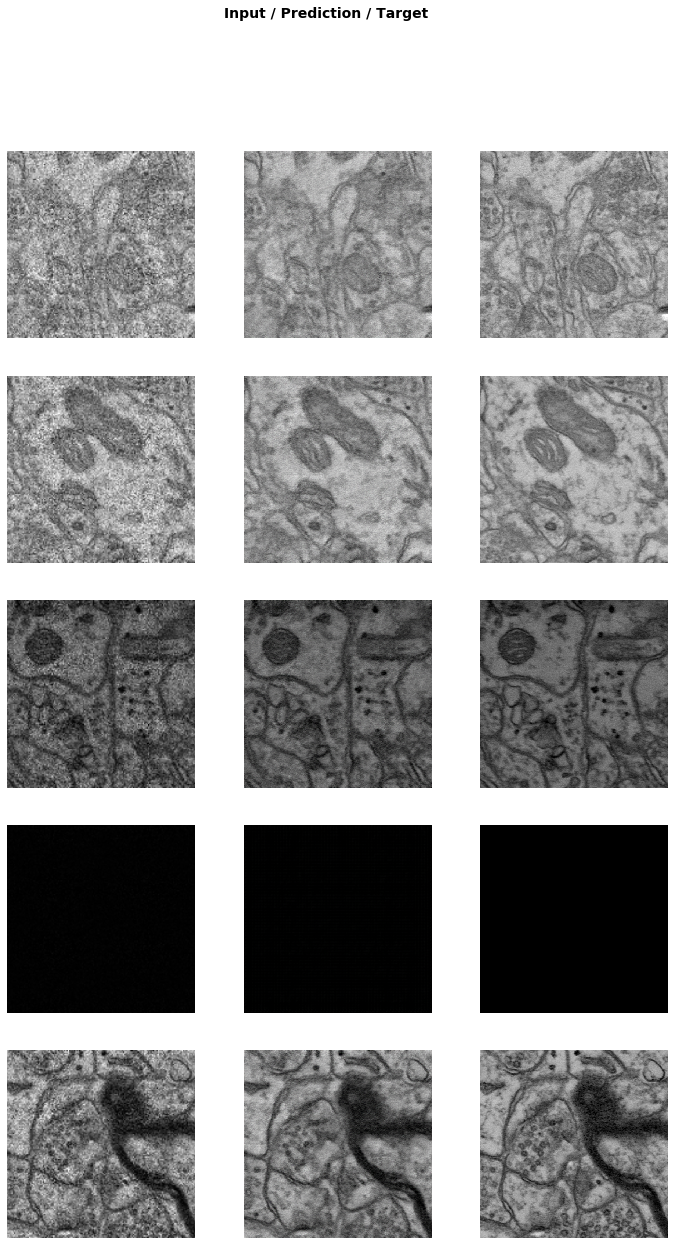

In [24]:
learn.show_results()

### Toddler pretrained critic, sampled generator with transfer learning from critic

In [25]:
model_name = '5.21_inpaint_transfer_toddler_sampled_3.pkl'
learn.model.load_state_dict(torch.load(model_pth/model_name))

<All keys matched successfully>

In [26]:
learn.validate()

[0.48184058, tensor(0.0788), tensor(19.3199), tensor(0.2203)]

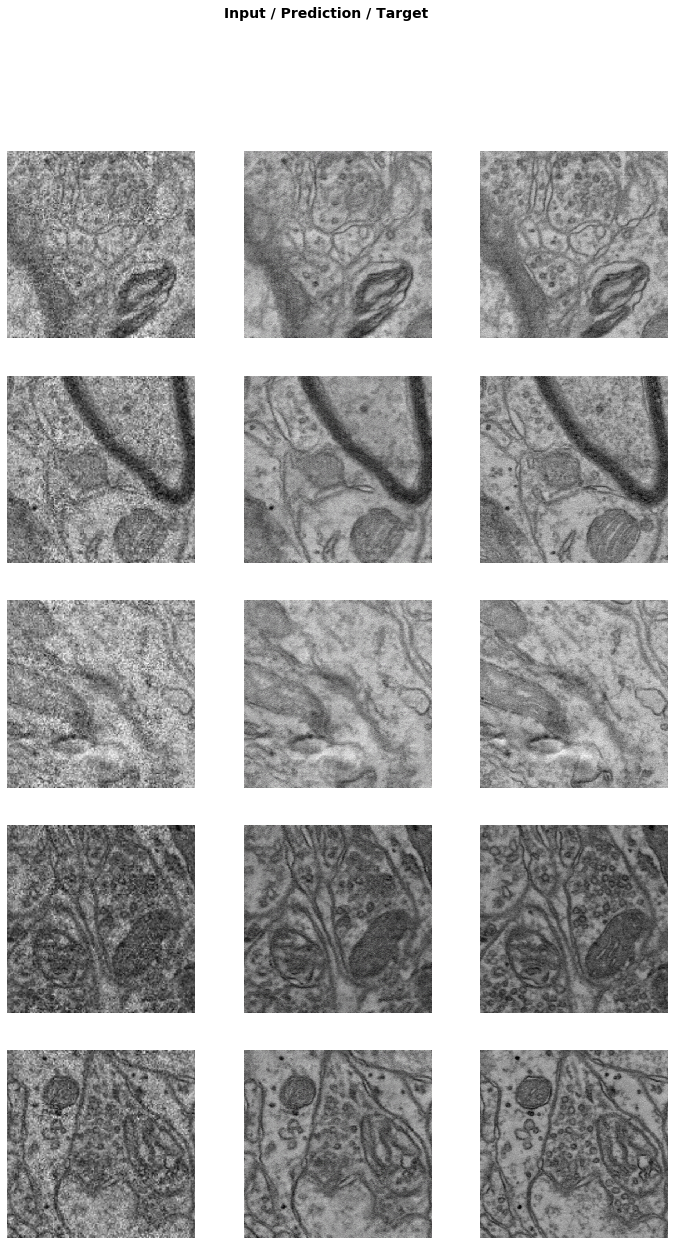

In [27]:
learn.show_results()